# Analysing Brownian dynamics simulations of condensate formation with option for surface condensation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import readdy
import math
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
import time
import scipy.integrate as integrate
print(readdy.__version__)
from scipy.spatial.transform import Rotation as Rot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import measure   
import matplotlib.gridspec as gridspec
from sklearn.cluster import DBSCAN
from sklearn import metrics
from collections import Counter
from jakteristics import compute_features
import matplotlib.patches as patches
from pylab import setp
import copy


2.0.12-1


# Visualizing 2D slice of simulation

In [2]:
#load saved config
traj=readdy.Trajectory("/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5602.h5")

times,types,ids,part_positions=traj.read_observable_particles()

#part_pos_eq=part_positions
time_e, energy=traj.read_observable_energy()

In [3]:
#selecting particle coordinates in 2D slice
def select_slice(part_positions_load,types_load,type_particle,slice_start,slice_stop,coord=3,dt=-1):
    #list to fill with coordinates:
    slice_coords=[]
    #iterate over all particle positions at time point dt:
    for i in range(len(part_positions_load[dt])):
        #get x,y,z coordinates for each particle
        coords_x=part_positions_load[dt][i][0]
        coords_y=part_positions_load[dt][i][1]
        coords_z=part_positions_load[dt][i][2] 
        #print(coords_x,coords_y,coords_z)
        #test if coord falls in section and is correct particle type
        if coord==1:
            coords_test=coords_x
            coords_append=[coords_y,coords_z]
        if coord==2:
            coords_test=coords_y
            coords_append=[coords_x,coords_z]
        if coord==3:
            coords_test=coords_z
            coords_append=[coords_x,coords_y]
            
        if (slice_start<coords_test<slice_stop) and type_particle==types_load[dt][i]:
            slice_coords.append(coords_append)
            
    return np.asarray(slice_coords)
    

In [4]:

t_eval_1=-1
int_size_1=10000
axis_1=2
slice_coords_test=select_slice(part_positions_load=part_positions,types_load=types,type_particle=0,slice_start=-int_size_1,slice_stop=int_size_1,coord=axis_1,dt=t_eval_1)


slice_coords_test2=select_slice(part_positions_load=part_positions,types_load=types,type_particle=2,slice_start=-int_size_1,slice_stop=int_size_1,coord=axis_1,dt=t_eval_1)


slice_coords_test3=select_slice(part_positions_load=part_positions,types_load=types,type_particle=3,slice_start=-int_size_1,slice_stop=int_size_1,coord=axis_1,dt=t_eval_1)



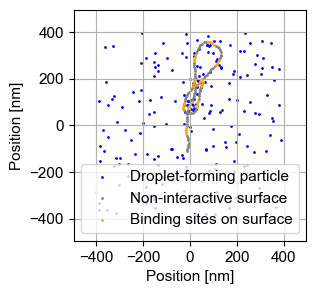

In [6]:
plt.figure(figsize=(3,3))
axis_l1=[-400,-200,0,200,400]
ax1= plt.subplot()

color_ch1="blue"
color_ch2="grey"
color_ch3="orange"

ax1.scatter([-450,-450,450,450],[-450,450,450,-450],s=30,color="white") #make sure that same size for plots

ax1.scatter(slice_coords_test[:,0],slice_coords_test[:,1],s=1,color=color_ch1,label="Droplet-forming particle")

ax1.scatter(slice_coords_test2[:,0],slice_coords_test2[:,1],s=1,color=color_ch2,label="Non-interactive surface")

ax1.scatter(slice_coords_test3[:,0],slice_coords_test3[:,1],s=1,color=color_ch3,label="Binding sites on surface")

plt.legend(loc="lower center",prop={'family': 'Arial','size': 11})
plt.xticks(fontname = "Arial",fontsize=11)
plt.yticks(fontname = "Arial",fontsize=11)
plt.ylabel("Position [nm]",fontname = "Arial",fontsize=11)
plt.xlabel("Position [nm]",fontname = "Arial",fontsize=11)
plt.grid()

# Get discretized coordinates and turn slice into image to use image analysis tools

This could allow to compare simulated results with experimental results recorded via microscopy

In [7]:
#code from:
#https://stackoverflow.com/questions/62778939/python-fastest-way-to-map-continuous-coordinates-to-discrete-grid


def gen_discretized_coords_3D(offset,resultion,part_positions_load,num_pixels,dt=-1):
    #offset=shift all particles to positiv positions
    #resolution = size of pixel
    #num_pixels = how many discrete pixels does final image-like output have
    image_disc=np.zeros((num_pixels,num_pixels,num_pixels))
    
    for i in range(len(part_positions_load[dt])):
        shift_coords=part_positions_load[dt][i] +offset
        image_disc_index=np.round( (shift_coords-resultion/2) /resultion)
        id0=int(image_disc_index[0])
        id1=int(image_disc_index[1])
        id2=int(image_disc_index[2])
        
        image_disc[id0,id1,id2]=image_disc[id0,id1,id2]+1
        
        #print(shift_coords,image_disc_index)
    return image_disc

In [8]:
image_disc_test=gen_discretized_coords_3D(offset=450,resultion=10,part_positions_load=part_positions,num_pixels=45*2,dt=-1)

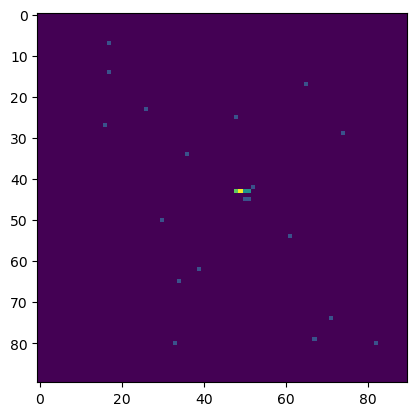

In [9]:
z_sum=np.sum(image_disc_test[:,:,40:50], axis=2)
plt.imshow(z_sum)
  

# Get coordinates of one type of particle at one time point

In [10]:
def coord_types_dt(part_positions_load,types_load,dt=-1):
    part_positions_type_0=[]
    part_positions_type_1=[]
    part_positions_type_2=[]
    part_positions_type_3=[]
    
    for i in range(len(part_positions_load[dt])):
        if types_load[dt][i]==0:
            part_positions_type_0.append(part_positions_load[dt][i])
        if types_load[dt][i]==1:
            part_positions_type_1.append(part_positions_load[dt][i])
        if types_load[dt][i]==2:
            part_positions_type_2.append(part_positions_load[dt][i])
        if types_load[dt][i]==3:
            part_positions_type_3.append(part_positions_load[dt][i])
        
        
    return part_positions_type_0,part_positions_type_1,part_positions_type_2,part_positions_type_3

In [11]:
part_positions_type_0,part_positions_type_1,part_positions_type_2,part_positions_type_3=coord_types_dt(part_positions_load=part_positions,types_load=types,dt=-1)

In [12]:
print(len(part_positions_type_3))

40


In [13]:
image_disc_type_0=gen_discretized_coords_3D(offset=450,resultion=10,part_positions_load=[part_positions_type_0],num_pixels=45*2,dt=-1)

image_disc_type_3=gen_discretized_coords_3D(offset=450,resultion=10,part_positions_load=[part_positions_type_3],num_pixels=45*2,dt=-1)

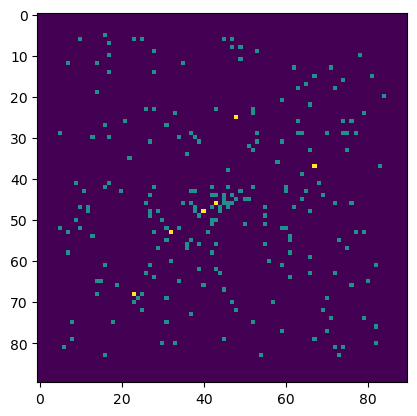

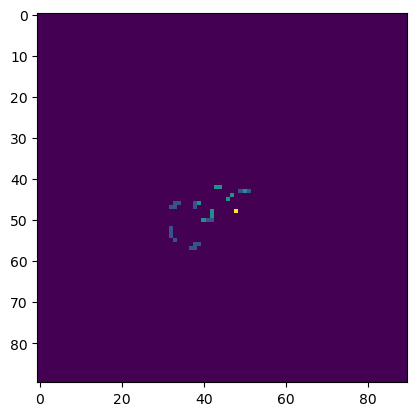

In [14]:
z_sum_type_0=np.sum(image_disc_type_0, axis=2)
plt.imshow(z_sum_type_0)
plt.show()

z_sum_type_3=np.sum(image_disc_type_3,axis=2)
plt.imshow(z_sum_type_3)
plt.show()

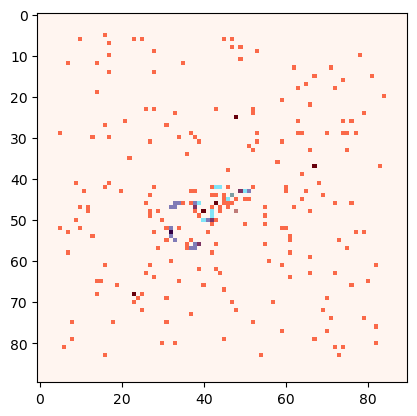

In [15]:
plt.figure()
ax1= plt.subplot()
z_sum_type_3_masked=np.ma.masked_where(z_sum_type_3 == 0, z_sum_type_3)
ax1.imshow(z_sum_type_0,alpha=1,cmap="Reds")
ax1.imshow(z_sum_type_3_masked,alpha=0.5,cmap="jet")

# Pearson correlation

In [16]:

#Pearson correlation between slices of coordinates of different particle types
def correlate_surface_ymotif(name_add,name_add_ref,num_sim,folder_name,t_eval=-1):
    #PC with surface
    pc_surf=[]
    pc_surf_error=[]

    #PC without surface 
    pc_ref=[]
    pc_ref_error=[]

    #1. load files 
    for k in range(len(name_add)):
        i=name_add[k]
        
        pc_surf_e=[]
        pc_ref_e=[]
        for j in range(num_sim):
            #name of sim with surface
            file_name=folder_name+"effective_droplet_"+str(int(i)+int(j))+".h5"
           
            traj_db1=readdy.Trajectory(file_name)

            times_db1,types_db1,ids_db1,part_positions_db1=traj_db1.read_observable_particles()
            
            #name of sim without surface
            file_name_ref=folder_name+"effective_droplet_"+str(int(name_add_ref[k])+int(j))+".h5"
           
            traj_db1_ref=readdy.Trajectory(file_name_ref)

            times_db1_ref,types_db1_ref,ids_db1_ref,part_positions_db1_ref=traj_db1_ref.read_observable_particles()
            
            
            
            
            #2. channels 
            #with surface
            part_positions_type_0,part_positions_type_1,part_positions_type_2,part_positions_type_3=coord_types_dt(part_positions_load=part_positions_db1,types_load=types_db1,dt=t_eval)
            
            #witout surface
            part_positions_type_0_ref,part_positions_type_1_ref,part_positions_type_2_ref,part_positions_type_3_ref=coord_types_dt(part_positions_load=part_positions_db1_ref,types_load=types_db1_ref,dt=t_eval)
          
            
            #3. convert to image
            #with surface
            
            #y-motifs
            part_positions_type_0_image=gen_discretized_coords_3D(offset=450,resultion=5,part_positions_load=[part_positions_type_0],num_pixels=180,dt=-1)  
            #surface attractive
            part_positions_type_3_image=gen_discretized_coords_3D(offset=450,resultion=5,part_positions_load=[part_positions_type_3],num_pixels=180,dt=-1)
            
            #without surface
            #y-motifs
            part_positions_type_0_image_ref=gen_discretized_coords_3D(offset=450,resultion=5,part_positions_load=[part_positions_type_0_ref],num_pixels=180,dt=-1)  
                
            
            #4. whole image or slice: image_disc_test[:,:,z_start:z_stop]
            #with surface
            part_positions_type_0_image=part_positions_type_0_image[:,:,:]
            part_positions_type_3_image=part_positions_type_3_image[:,:,:]
            
            part_positions_type_0_image_sum=np.sum(part_positions_type_0_image,axis=0)
            part_positions_type_3_image_sum=np.sum(part_positions_type_3_image,axis=0)

            
            #without surface
            part_positions_type_0_image_ref=part_positions_type_0_image_ref[:,:,:]
            part_positions_type_0_image_ref_sum=np.sum(part_positions_type_0_image_ref,axis=0)
            
            #5. PC correlation
            #surface-particles 
            pc_03=np.corrcoef(part_positions_type_0_image_sum.flatten(),part_positions_type_3_image_sum.flatten())[0][1]
            #print(pc_03)
            pc_surf_e.append(pc_03)
            
            #surface-particles reference case
            pc_03_ref=np.corrcoef(part_positions_type_0_image_ref_sum.flatten(),part_positions_type_3_image_sum.flatten())[0][1]
            
            pc_ref_e.append(pc_03_ref)
        #print("surface",pc_surf_e)
        #print("ref",pc_ref_e)
        #with surface
        pc_surf_e_mean=np.mean(pc_surf_e)
        pc_surf_e_error=np.std(pc_surf_e) /np.sqrt(len(pc_surf_e))

        pc_surf.append(pc_surf_e_mean)
        pc_surf_error.append(pc_surf_e_error)
        
        #without surface
        pc_ref_e_mean=np.mean(pc_ref_e)
        pc_ref_e_error=np.std(pc_ref_e) /np.sqrt(len(pc_ref_e))

        pc_ref.append(pc_ref_e_mean)
        pc_ref_error.append(pc_ref_e_error)
                
        
    return pc_surf,pc_surf_error,pc_ref,pc_ref_error


In [17]:
pc_surf_1,pc_surf_error_1,pc_ref_1,pc_ref_error_1=correlate_surface_ymotif(name_add=[5200,5300,5400,5500,5600,5700,5800,5900,51000,51100],name_add_ref=[200,300,400,500,600,700,800,900,1000,1100],num_sim=10,folder_name="/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/",t_eval=667)

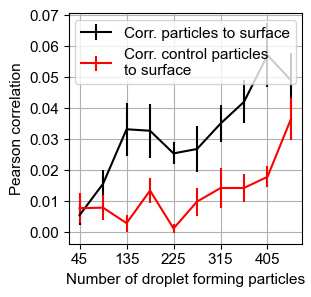

In [18]:
plt.figure(figsize=(3,3))
ax1= plt.subplot()
num_y_motifs=[45,90,135,180,225,270,315,360,405,450]
num_y_motifs_2=[45,135,225,315,405]
ax1.errorbar(num_y_motifs,pc_surf_1,yerr=pc_surf_error_1,color="black",label="Corr. particles to surface")
ax1.errorbar(num_y_motifs,pc_ref_1,yerr=pc_ref_error_1,color="red",label="Corr. control particles \nto surface")
plt.legend(prop={'family': 'Arial','size': 11},loc="upper center")
plt.xticks(num_y_motifs_2,num_y_motifs_2,fontname = "Arial",fontsize=11)
plt.yticks(fontname = "Arial",fontsize=11)
plt.ylabel("Pearson correlation",fontname = "Arial",fontsize=11)
plt.xlabel("Number of droplet forming particles",fontname = "Arial",fontsize=11)
plt.grid()
#plt.savefig("/home/aaron/phd/files_effective_droplet_1/figures_surface/pearson_corr_surf_t_667_1.pdf",bbox_inches="tight",format="pdf")
#plt.savefig("/home/aaron/phd/files_effective_droplet_1/figures_surface/pearson_corr_surf_t_m1_1.pdf",bbox_inches="tight",format="pdf")

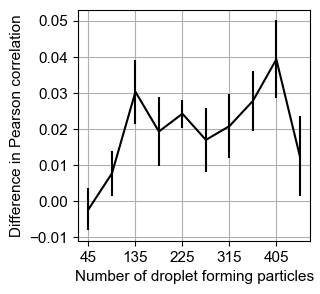

In [19]:
plt.figure(figsize=(3,3))
ax1= plt.subplot()
yerr_diff=np.sqrt( np.asarray(pc_surf_error_1)**2 + np.asarray(pc_ref_error_1)**2 )
ax1.errorbar(num_y_motifs,np.asarray(pc_surf_1)-np.asarray(pc_ref_1),yerr=yerr_diff,color="black")
#plt.legend(prop={'family': 'Arial','size': 11},loc="upper center")
plt.xticks(num_y_motifs_2,num_y_motifs_2,fontname = "Arial",fontsize=11)
plt.yticks(fontname = "Arial",fontsize=11)
plt.ylabel("Difference in Pearson correlation",fontname = "Arial",fontsize=11)
plt.xlabel("Number of droplet forming particles",fontname = "Arial",fontsize=11)
plt.grid()

# DB-scan detected clusters 

In [20]:
#get average numbers/volumes of droplets
def avg_dr(add_num,tot_num,name,folder,t_eval=-1):
    #input:
    #add_num = number to add to get desired simulation run
    #tot_num = number of conditions for wich to generate averages
    #t_eval = which time point to evaluate
    
    #output:
    #drop_num,drop_num_std_e = mean number of droplets, std error of number of droplets
    #part_in_drop,part_in_drop_std_e = mean number of particles in droplets, std error of number of particles in droplets
    
    #folder="files_effective_droplet_1/runs_depth_1/"
    
    drop_num=[]
    part_in_drop=[]
    drop_num_std_e=[]
    part_in_drop_std_e=[]
    
    for i in add_num:
        drop_num_e=[]
        part_in_drop_e=[]
        
        for j in range(tot_num):
            file_name=folder+name+str(int(i)+int(j))+".h5"
            print(file_name)
            traj_db1=readdy.Trajectory(file_name)

            times_db1,types_db1,ids_db1,part_positions_db1=traj_db1.read_observable_particles()
            
            
            

        
            #iterate over every particle, only choose specific particle
            P_n = len(part_positions_db1[t_eval])
            part_positions_db1f=[]
            for p in range(P_n):
                if traj_db1.species_name(types_db1[t_eval][p]) =="core":
                    part_positions_db1f.append(part_positions_db1[t_eval][p])
            
            X=np.asarray(part_positions_db1f)
            print("number of particles for DBSCAN:",len(X))
            
            #use all particle positions 
            #X=part_positions_db1[t_eval]
            #print(len("number of particles for DBSCAN:",X))
            
            #perform dbscan
            db = DBSCAN(eps=40, min_samples=10).fit(X)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            #print(n_clusters_)
            
            #get particles per cluster 
            counter_labels=Counter(labels)

            counter_labels=dict(counter_labels)

            counter_numbers=[]

            for key, value in counter_labels.items():
                #en=counter_labels{i}
                if key !=-1:
                    counter_numbers.append(value)
            counter_numbers=np.asarray(counter_numbers)
            
            #get mean particle number
            mean_cluster_number=np.mean(counter_numbers)
            
            #append number of droplets and mean number of particles per droplet
            
            drop_num_e.append(n_clusters_)
            if mean_cluster_number>0:
                part_in_drop_e.append(mean_cluster_number)
        print(drop_num_e,part_in_drop_e)
        #get average values for all sim runs with one condition
        
        drop_num.append(np.mean(drop_num_e))
        drop_num_std_e.append(np.std(drop_num_e)/np.sqrt(len(drop_num_e)))
        
        #fill with zeros if no droplets are detected
        if len(part_in_drop_e)>0:
            part_in_drop.append(np.mean(part_in_drop_e))
        if len(part_in_drop_e)==0:
             part_in_drop.append(0)
            
        
          
        
        if len(part_in_drop_e)>0:
            part_in_drop_std_e.append(np.std(part_in_drop_e)/np.sqrt(len(part_in_drop_e)))
        if len(part_in_drop_e)==0:
             part_in_drop_std_e.append(0)
                
                
    return drop_num,drop_num_std_e,part_in_drop,part_in_drop_std_e

# Influence of surface on number of droplets

In [21]:
#average number of droplets with surface
add_num_1=[5200,5300,5400,5500,5600,5700,5800,5900,51000,51100]
folder_1="/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/"
name_1="effective_droplet_"
#get mean values
drop_num_1,drop_num_std_e_1,part_in_drop_1,part_in_drop_std_e_1=avg_dr(add_num=add_num_1,name=name_1,folder=folder_1,tot_num=10,t_eval=-1)

/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5200.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5201.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5202.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5203.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5204.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5205.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5206.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5207.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5208.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5209.h5
number of particles for DBSCAN: 45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] []
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5300.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5301.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5302.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5303.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5304.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5305.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5306.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5307.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5308.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5309.h5
number of particles for DBSCAN: 90
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] []
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5400.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5401.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5402.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5403.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5404.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5405.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effecti

/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5407.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5408.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5409.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 135
[1, 1, 1, 0, 0, 1, 2, 0, 0, 0] [10.0, 11.0, 10.0, 13.0, 13.0]
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5500.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5501.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5502.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5503.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5504.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5505.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5506.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5507.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5508.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5509.h5
number of particles for DBSCAN: 180
[2, 2, 1, 0, 2, 0, 0, 0, 1, 0] [16.0, 10.5, 16.0, 13.5, 13.0]
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5600.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5601.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5602.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5603.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5604.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5605.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5606.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5607.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5608.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5609.h5
number of particles for DBSCAN: 225
[1, 1, 2, 1, 0, 1, 1, 2, 1, 1] [15.0, 24.0, 12.0, 58.0, 54.0, 20.0, 28.5, 11.0, 23.0]
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5700.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5701.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5702.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5703.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5704.h5
number of p

/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5707.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5708.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5709.h5
number of particles for DBSCAN: 270
[3, 1, 1, 1, 2, 0, 2, 1, 2, 2] [27.666666666666668, 62.0, 12.0, 12.0, 32.5, 25.0, 19.0, 26.5, 27.0]
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5800.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5801.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5802.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_5803.

In [22]:
#average number of droplets without surface
add_num_2=[200,300,400,500,600,700,800,900,1000,1100]
folder_2="/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/"
name_2="effective_droplet_"
#get mean values
drop_num_2,drop_num_std_e_2,part_in_drop_2,part_in_drop_std_e_2=avg_dr(add_num=add_num_2,name=name_2,folder=folder_1,tot_num=10,t_eval=-1)

/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_200.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_201.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_202.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_203.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_204.h5
number of particles for DBSCAN: 45


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_205.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_206.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_207.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_208.h5
number of particles for DBSCAN: 45
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_209.h5
number of particles for DBSCAN: 45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] []
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_300.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_301.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_302.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_303.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_304.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_305.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_306.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_307.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_308.h5
number of particles for DBSCAN: 90
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_309.h5
number of particles for DBSCAN: 90
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] []
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_400.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_401.h5
number of particles for DBSCAN: 135


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_402.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_403.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_404.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_405.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_406.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_407.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_408.h5
number of particles for DBSCAN: 135
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_409.h5
number of particles for DBSCAN: 135
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] []
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_500.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_501.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_502.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_503.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_504.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_505.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_506.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_507.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_508.h5
number of particles for DBSCAN: 180
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_509.h5
number of particles for DBSCAN: 180
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] []
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_600.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_601.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_602.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_603.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_604.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_605.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_606.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_607.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_608.h5
number of particles for DBSCAN: 225
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_609.h5
number of particles for DBSCAN: 225
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] []
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_700.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_701.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_702.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_703.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_704.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_705.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_706.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_707.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_708.h5
number of particles for DBSCAN: 270
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_709.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 270
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [12.0]
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_800.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_801.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_802.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_803.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_804.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_805.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_806.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/

number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_807.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_808.h5
number of particles for DBSCAN: 315
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_809.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 315
[0, 1, 1, 0, 1, 0, 0, 0, 0, 1] [87.0, 66.0, 48.0, 97.0]
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_900.h5
number of particles for DBSCAN: 360
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_901.h5
number of particles for DBSCAN: 360
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_902.h5
number of particles for DBSCAN: 360
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_903.h5
number of particles for DBSCAN: 360
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_904.h5
number of particles for DBSCAN: 360
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_905.h5
number of particles for DBSCAN: 360
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_test/effective_droplet_906.h5
number of particles for DBSCAN: 360
/home/aaron/

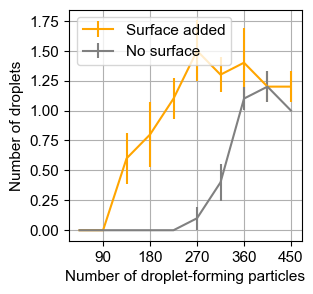

In [44]:
fig_size=3
font_size=11 #9
#plt.figure(figsize=(3,3))
plt.figure(figsize=(fig_size,fig_size))
num_y_motifs=[45,90,135,180,225,270,315,360,405,450]
num_y_motifs_2=[45,135,225,315,405]
num_y_motifs_2=[90,180,270,360,450]
ax1= plt.subplot()
ax1.errorbar(num_y_motifs,drop_num_1,yerr=drop_num_std_e_1,label="Surface added",color="orange")
ax1.errorbar(num_y_motifs,drop_num_2,yerr=drop_num_std_e_2,label="No surface",color="grey")
plt.legend(prop={'family': 'Arial','size': font_size})
plt.xticks(num_y_motifs_2,num_y_motifs_2,fontname = "Arial",fontsize=font_size)
plt.yticks(fontname = "Arial",fontsize=font_size)
plt.ylabel("Number of droplets",fontname = "Arial",fontsize=font_size)
plt.xlabel("Number of droplet-forming particles",fontname = "Arial",fontsize=font_size)
plt.grid()
#plt.savefig("/home/aaron/phd/files_effective_droplet_1/figures_surface/number_droplets_surf_t_667_1.pdf",bbox_inches="tight",format="pdf")
#plt.savefig("/home/aaron/phd/files_effective_droplet_1/figures_surface/number_droplets_surf_t_m1_2.pdf",bbox_inches="tight",format="pdf")
#plt.savefig("/home/aaron/phd/files_effective_droplet_1/figures_surface/number_droplets_surf_t_m1_1.png",bbox_inches="tight",format="png",dpi=300)

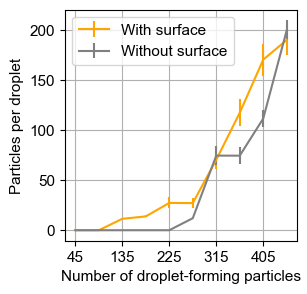

In [33]:
plt.figure(figsize=(3,3))
num_y_motifs=[45,90,135,180,225,270,315,360,405,450]
num_y_motifs_2=[45,135,225,315,405]
ax1= plt.subplot()
ax1.errorbar(num_y_motifs,part_in_drop_1,part_in_drop_std_e_1,label="With surface",color="orange")
ax1.errorbar(num_y_motifs,part_in_drop_2,part_in_drop_std_e_2,label="Without surface",color="grey")
plt.legend(prop={'family': 'Arial','size': 11})
plt.xticks(num_y_motifs_2,num_y_motifs_2,fontname = "Arial",fontsize=11)
plt.yticks(fontname = "Arial",fontsize=11)
plt.ylabel("Particles per droplet",fontname = "Arial",fontsize=11)
plt.xlabel("Number of droplet-forming particles",fontname = "Arial",fontsize=11)
plt.grid()

# Influence of surface on amphiphile 

Data for amphiphile titration without surface was part of the following publication: https://pubs.acs.org/doi/10.1021/acs.nanolett.3c01301

In [25]:
#average number of droplets with surface
add_num_am_1=[25000,24000,23000,22000,21000,20000,210000,29000,28000,27000,26000]
folder_am_1="/home/aaron/phd/files_effective_droplet_1/runs_depth_1/"  #simulation runs are shorter 
name_am_1="effective_droplet_1"

#get mean values
drop_num_am_1,drop_num_std_e_am_1,part_in_drop_am_1,part_in_drop_std_e_am_1=avg_dr(add_num=add_num_am_1,name=name_am_1,folder=folder_am_1,tot_num=20,t_eval=-1)

/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_125000.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_125001.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_125002.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_125003.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_125004.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_125005.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_125006.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_125007.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_d

number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_122004.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_122005.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_122006.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_122007.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_122008.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_122009.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_122010.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_122011.h5
number of particles for DBSCAN: 450
/home/aaron/

/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_1210006.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_1210007.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_1210008.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_1210009.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_1210010.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_1210011.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_1210012.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_1210013.h5
number of particles for DBSCAN: 450
/hom

/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129002.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129003.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129004.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129005.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129006.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129007.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129008.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129009.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129010.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129011.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129012.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129013.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129014.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129015.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129016.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129017.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129018.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_129019.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
[0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0] [36.0, 17.0, 34.0, 35.0, 16.0, 17.5, 10.0, 14.0, 25.0, 16.0, 24.0, 19.0]
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128000.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128001.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128002.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128003.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128004.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128005.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128006.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128007.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128008.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128009.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128010.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128011.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128012.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128013.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128014.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128015.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128016.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128017.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128018.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_128019.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] [11.0, 19.0]
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127000.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127001.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127002.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127003.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127004.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127005.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127006.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127007.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127008.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127009.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127010.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127011.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127012.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127013.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127014.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127015.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127016.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127017.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127018.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_127019.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] []
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126000.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126001.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126002.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126003.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126004.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126005.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126006.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126007.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126008.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126009.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126010.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126011.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126012.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126013.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126014.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126015.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126016.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126017.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126018.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/runs_depth_1/effective_droplet_126019.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] []


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


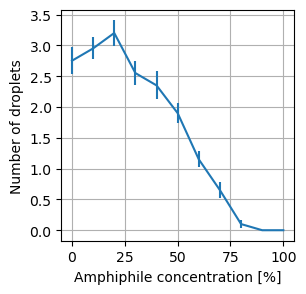

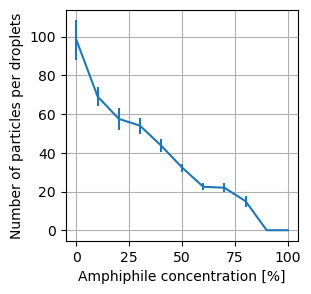

In [26]:
plt.figure(figsize=(3,3))

ax1= plt.subplot()

cases_c1=[0,10,20,30,40,50,60,70,80,90,100]


ax1.errorbar(cases_c1,drop_num_am_1,yerr=drop_num_std_e_am_1)
plt.ylabel("Number of droplets")
plt.xlabel("Amphiphile concentration [%]")
plt.grid()
plt.show()


plt.figure(figsize=(3,3))

ax1= plt.subplot()
ax1.errorbar(cases_c1,part_in_drop_am_1,yerr=part_in_drop_std_e_am_1)
plt.ylabel("Number of particles per droplets")
plt.xlabel("Amphiphile concentration [%]")
plt.grid()
plt.show()

In [27]:
#average number of droplets with surface
add_num_am_2=[0,450,900,1350,1800,2250,2700,3150,3600,4050,4500]
folder_am_2="/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/"
name_am_2="effective_droplet_"

#get mean values
drop_num_am_2,drop_num_std_e_am_2,part_in_drop_am_2,part_in_drop_std_e_am_2=avg_dr(add_num=add_num_am_2,name=name_am_2,folder=folder_am_2,tot_num=10,t_eval=667)

/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_0.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_1.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_2.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_3.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_5.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_6.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_d

number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_2258.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_2259.h5
number of particles for DBSCAN: 450
[4, 5, 4, 6, 8, 5, 5, 4, 5, 5] [30.75, 22.6, 25.25, 23.833333333333332, 15.75, 25.0, 26.0, 25.75, 20.2, 22.2]
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_2700.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_2701.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_2702.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_2703.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_run

/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4053.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4054.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4055.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4056.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4057.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4058.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4059.h5
number of particles for DBSCAN: 450
[2, 0, 2, 2, 3, 2, 3, 3, 3

/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4503.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4504.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4505.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4506.h5


/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4507.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4508.h5
number of particles for DBSCAN: 450
/home/aaron/phd/files_effective_droplet_1/test_runs_1/surface_amph_test/effective_droplet_4509.h5
number of particles for DBSCAN: 450
[3, 0, 1, 0, 0, 0, 3, 2, 3, 1] [11.333333333333334, 10.0, 14.333333333333334, 16.0, 11.333333333333334, 13.0]


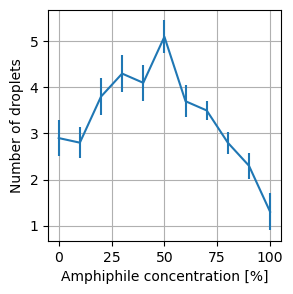

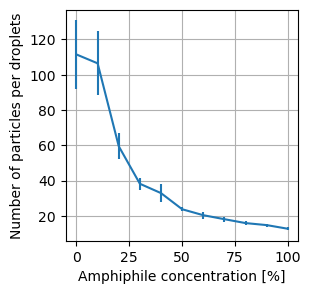

In [28]:
plt.figure(figsize=(3,3))

ax1= plt.subplot()

cases_c1=[0,10,20,30,40,50,60,70,80,90,100]


ax1.errorbar(cases_c1,drop_num_am_2,yerr=drop_num_std_e_am_2)
plt.ylabel("Number of droplets")
plt.xlabel("Amphiphile concentration [%]")
plt.grid()
plt.show()


plt.figure(figsize=(3,3))

ax1= plt.subplot()
ax1.errorbar(cases_c1,part_in_drop_am_2,yerr=part_in_drop_std_e_am_2)
plt.ylabel("Number of particles per droplets")
plt.xlabel("Amphiphile concentration [%]")
plt.grid()
plt.show()

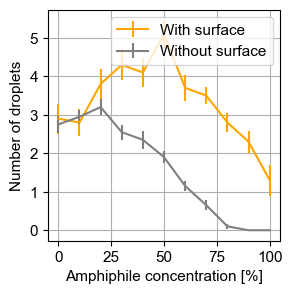

In [29]:
plt.figure(figsize=(3,3))

ax1= plt.subplot()

cases_c1=[0,10,20,30,40,50,60,70,80,90,100]

ax1.errorbar(cases_c1,drop_num_am_2,yerr=drop_num_std_e_am_2,label="With surface",color="orange")
ax1.errorbar(cases_c1,drop_num_am_1,yerr=drop_num_std_e_am_1,label="Without surface",color="grey")

plt.legend(prop={'family': 'Arial','size': 11})
plt.xticks(fontname = "Arial",fontsize=11)
plt.yticks(fontname = "Arial",fontsize=11)
plt.ylabel("Number of droplets",fontname = "Arial",fontsize=11)
plt.xlabel("Amphiphile concentration [%]",fontname = "Arial",fontsize=11)
plt.grid()
#plt.show()
#plt.savefig("/home/aaron/phd/files_effective_droplet_1/figures_surface/titration_amph_surf_1.pdf",bbox_inches="tight",format="pdf")